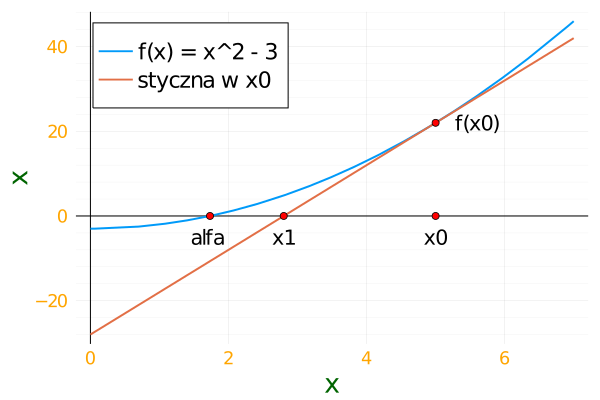

In [129]:
using Plots

x0 = 5

f(x) = x^2 - 3
g(x) = 2x

h(x) = g(x0) * x + f(x0) - g(x0) * x0

default(tickfont = (12, :orange), framestyle = :zerolines)
plot([f, h], 0, 7, linewidth = 2, label = ["f(x) = x^2 - 3" "styczna w x0"], legend = :topleft)
annotate!((5.6, 22, "f(x0)"), (2.8, -5, "x1"), (5, -5, "x0"), (1.7, -5, "alfa"))
scatter!([(5, 22), (5, 0), (2.8, 0), (sqrt(3), 0)], c = :red, label = false)
